# Titanic Logistic Regression

In this notebook we will use Logistic Regression to predict if a passenger have survived or not to the Titanic accident.
We will use the 'Titanic: Machine Learning from Disaster' dataset from Kaggle https://www.kaggle.com/c/titanic.

In [120]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [105]:
# Read the training set
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Data Visualization

Usually in most of the dataset, the are missing values. We will check how many missing values are present in our dataset using seaborn heatmap

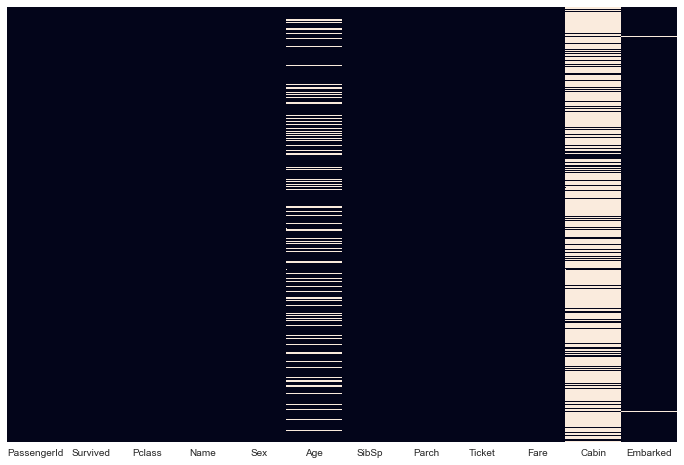

In [58]:
sns.set_style('whitegrid')
plt.subplots(figsize = (12,8))
sns.heatmap(train.isnull(), yticklabels = False, cbar = False)

From this graph we can visualize where the missing data are located. The missing data are shown in the heatmap with a white color. As we can see, there are some missing data under the 'Age' column, lot of missing data under the 'Cabin' column and just few of them under the 'Embarked' column.

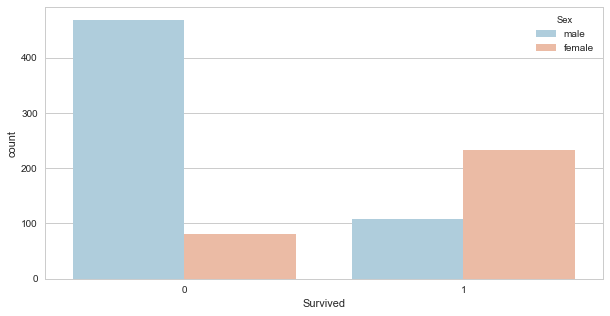

In [38]:
# Count plot of survived people by Sex
plt.subplots(figsize=(10,5))
sns.countplot(x = 'Survived', data = train, hue = 'Sex', palette = 'RdBu_r')

From this countplot we can notice that there is a trend in our data, in fact people that not survive were much more likely to be male.

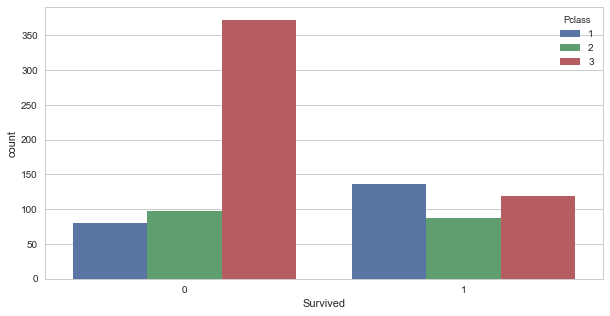

In [40]:
# Count plot of survived people by PClass
plt.subplots(figsize=(10,5))
sns.countplot(x = 'Survived', data = train, hue = 'Pclass')

From this countplot we can see that most of the people that did not survive belong to the 3rd class, that was the cheapest one

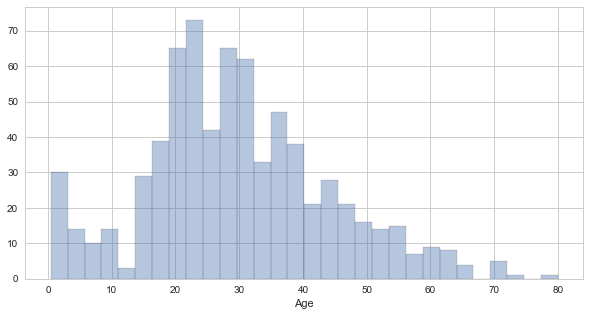

In [48]:
plt.rcParams["patch.force_edgecolor"] = True
plt.subplots(figsize=(10,5))
sns.distplot(train['Age'].dropna(),kde = False, bins = 30)

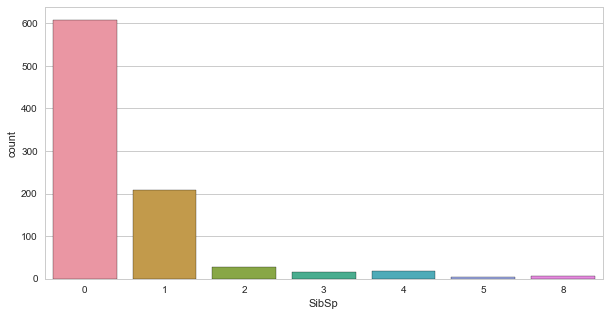

In [51]:
plt.subplots(figsize=(10,5))
sns.countplot(x = 'SibSp', data = train)

Form this graph we can see that most of the passenger of the Titanic have no children or spouse

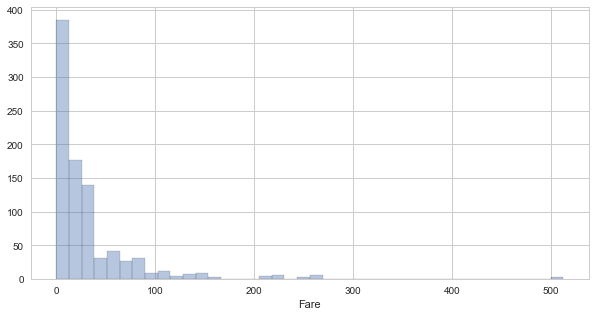

In [64]:
plt.subplots(figsize=(10,5))
sns.distplot(train['Fare'], kde = False, bins = 40)

Most of the fare are between 0 and 50, also because most of the passenger were in the cheapest class of the Titanic

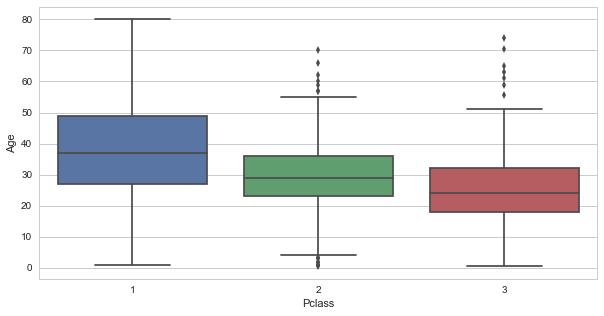

In [67]:
plt.subplots(figsize=(10,5))
sns.boxplot( x = 'Pclass', y = 'Age', data = train)

From this boxplot we can notice that in general, the age of the people in the first class was higher with respect to the age of people of the third class

In [106]:
# Function to impute data using the median values from the previous graph
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Now we will use the previously defined function to impute the Age values

In [107]:
# Imputation
train['Age'] = train [['Age','Pclass']].apply(impute_age, axis = 1)
print('Number of missing values in Age: ' + str(train['Age'].isnull().sum()))

Number of missing values in Age: 0


Since the number of missing values in the Cabin column is too high, the imputation won't be so useful.
For this reason we will drop that column from our dataset.

In [108]:
train.drop('Cabin', axis = 1, inplace = True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Finally since there are just few missing values on the Embarked column, we will simply drop those missing values

In [109]:
# Drop missing values
train.dropna(inplace = True)
# Check that there are no other missing values
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Now we will deal with categorical features.
We will create a dummy variable for sex and we will drop one of the column because of the multicollinearity. In fact, our machine learning algorithm will need just one single column, because it can linearly predict the other class from that, since the are just two possible outcomes (binary class).

In [110]:
sex = pd.get_dummies(train['Sex'], drop_first = True)
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


Let's do the same for the Embarked column

In [112]:
embark = pd.get_dummies(train['Embarked'], drop_first = True)
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [113]:
train = pd.concat([train,sex,embark], axis = 1)
train.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'PassengerId'], axis = 1, inplace = True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [122]:
X = train.drop('Survived', axis = 1)
y = train['Survived']

In [126]:
# Split in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Predictions

Now we will create our Logistic Regression model and we will use it to predict our target variable y

In [137]:
# Import
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [130]:
# Create istance of the model
logmodel = LogisticRegression()

In [131]:
# Fit the model on training data
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [138]:
# Predictions
predictions = logmodel.predict(X_test)

In [140]:
# Confusion matrix 
confusion_matrix(y_test, predictions)

array([[139,  20],
       [ 36,  72]], dtype=int64)

In [141]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.79      0.87      0.83       159
          1       0.78      0.67      0.72       108

avg / total       0.79      0.79      0.79       267

